## Install and import

In [4]:
import os
os.system("pip3 install -r requirements.txt")
from datamodel import OrderDepth, UserId, TradingState, Order, Listing, Observation, ConversionObservation
from typing import List, Dict, Tuple
import pandas as pd
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Tools

### Log Scraper

In [174]:
def log_to_json(logname: str) -> Dict:
    with open(logname, "r") as f:
        content = f.read() 
    # get trade_history
    th = content.split("Trade History:")[1]
    th = json.loads(th)

    # get orderbook
    ob = content.split("Activities log:")[1].split("profit_and_loss")[1].split("Trade History:")[0]

    return th, ob


all_trades, all_orders = log_to_json("logs/7.log")
all_trades

[{'timestamp': 0,
  'buyer': '',
  'seller': '',
  'symbol': 'AMETHYSTS',
  'currency': 'SEASHELLS',
  'price': 10004,
  'quantity': 1},
 {'timestamp': 0,
  'buyer': '',
  'seller': '',
  'symbol': 'STARFRUIT',
  'currency': 'SEASHELLS',
  'price': 5003,
  'quantity': 1},
 {'timestamp': 0,
  'buyer': '',
  'seller': '',
  'symbol': 'STARFRUIT',
  'currency': 'SEASHELLS',
  'price': 5003,
  'quantity': 13},
 {'timestamp': 1100,
  'buyer': '',
  'seller': '',
  'symbol': 'AMETHYSTS',
  'currency': 'SEASHELLS',
  'price': 9996,
  'quantity': 2},
 {'timestamp': 1700,
  'buyer': '',
  'seller': '',
  'symbol': 'STARFRUIT',
  'currency': 'SEASHELLS',
  'price': 5002,
  'quantity': 8},
 {'timestamp': 1700,
  'buyer': '',
  'seller': '',
  'symbol': 'AMETHYSTS',
  'currency': 'SEASHELLS',
  'price': 10002,
  'quantity': 1},
 {'timestamp': 1800,
  'buyer': '',
  'seller': '',
  'symbol': 'AMETHYSTS',
  'currency': 'SEASHELLS',
  'price': 10002,
  'quantity': 1},
 {'timestamp': 1900,
  'buyer': 

## Fake State Generator

In [6]:
def generate_random_state(product1_name: str, product2_name: str) -> TradingState:
    timestamp = random.randint(0, 1999) * 100
    traderData = ""

    listings = {
        product1_name: Listing(symbol=product1_name, product=product1_name, denomination="SEASHELLS"),
        product2_name: Listing(symbol=product2_name, product=product2_name, denomination="SEASHELLS"),
    }

    order_depths = {
        product1_name: OrderDepth(),
        product2_name: OrderDepth(),
    }

    # Generate random buy and sell orders for both products
    for product_name in [product1_name, product2_name]:
        order_depths[product_name].buy_orders = {price: quantity for price, quantity in zip(range(100, 105), random.sample(range(1, 10), 5))}
        order_depths[product_name].sell_orders = {price: -quantity for price, quantity in zip(range(106, 111), random.sample(range(1, 10), 5))}

    # Assuming no trades have occurred yet
    own_trades = {product1_name: [], product2_name: []}
    market_trades = {product1_name: [], product2_name: []}

    # Random initial positions for both products
    position = {
        product1_name: random.randint(-10, 10),
        product2_name: random.randint(-10, 10),
    }

    # Placeholder for observations with default values
    plainValueObservations = {product1_name: 0, product2_name: 0}
    conversionObservations = {product1_name: ConversionObservation(0, 0, 0, 0, 0, 0, 0),
                              product2_name: ConversionObservation(0, 0, 0, 0, 0, 0, 0)}

    observations = Observation(plainValueObservations=plainValueObservations, conversionObservations=conversionObservations)

    return TradingState(traderData, timestamp, listings, order_depths, own_trades, market_trades, position, observations)



## Sell Possible?

In [131]:
def can_sell(product: str, state: TradingState):
    print(state.position)
    return len(state.order_depths[product].buy_orders) > 0 and state.position[product]  > -10
    
can_sell("STARFRUIT", generate_random_state("STARFRUIT", "SEASHELLS"))


{'STARFRUIT': 1, 'SEASHELLS': -9}


True

## Visualizations

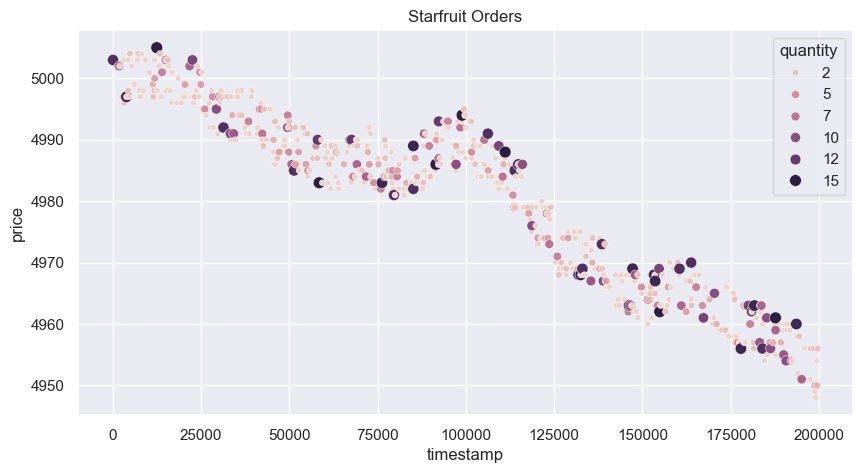

In [183]:
orders = pd.DataFrame(all_trades) # all trades is a list of dicts. the dicts are trades
orders['timestamp'] = pd.to_datetime(orders['timestamp'], unit='ms')

startfruit_orders = pd.DataFrame([order for order in all_trades if order['symbol'] == 'STARFRUIT'])
amethyst_orders = pd.DataFrame([order for order in all_trades if order['symbol'] == 'AMETHYSTS'])

amethyst_orders.to_csv('data/test/amethyst_orders.csv')

def starfruit_graph():
    g = sns.scatterplot(data=startfruit_orders, x='timestamp', y='price', size='quantity', hue='quantity')
    g.set_title('Starfruit Orders')
    g

def amethyst_graph(): # amethyst price is extremely stable
    g = sns.lineplot(data=amethyst_orders, x='timestamp', y='price')
    g.set_title('Amethyst Orders')
    g

starfruit_graph()



In [257]:
# all_orders format : day;timestamp;product;bid_price_1;bid_volume_1;bid_price_2;bid_volume_2;bid_price_3;bid_volume_3;ask_price_1;ask_volume_1;ask_price_2;ask_volume_2;ask_price_3;ask_volume_3;mid_price;profit_and_loss

df_all_orders = all_orders.split('\n')
df_all_orders = [x.split(';') for x in df_all_orders]
df_all_orders = pd.DataFrame(df_all_orders, columns=['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3', 'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss'])
df_all_orders = df_all_orders.dropna()
#df_all_orders.to_csv('data/test/all_orders.csv')


def correlations(product: str, state: TradingState, start: int = 0, end: int = 10):
    all_orders_for_product = df_all_orders[df_all_orders['product'] == product].iloc[start:end]
    ## going to use this function to view correlations between price of product and the observations such as temperature, etc
    
        
correlations('STARFRUIT', generate_random_state('STARFRUIT', 'SEASHELLS'))


   day timestamp    product bid_price_1 bid_volume_1 bid_price_2 bid_volume_2  \
2   -2         0  STARFRUIT        5002            1        4997           31   
4   -2       100  STARFRUIT        4997           24                            
5   -2       200  STARFRUIT        4997            2        4996           20   
8   -2       300  STARFRUIT        4996           31                            
10  -2       400  STARFRUIT        4995           27                            

   bid_price_3 bid_volume_3 ask_price_1 ask_volume_1 ask_price_2 ask_volume_2  \
2                                  5003           31                            
4                                  5003            2        5004           22   
5                                  5003           20                            
8                                  5003           31                            
10                                 5002           27                            

   ask_price_3 ask_volume_